# Sobreajuste e otimização hiperparamétrica



## Importanto as bibliotecas

In [ ]:
# TensorFlow
import tensorflow as tf

# Bibliotecas Auxiliares
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Instalando o KerasTuner.
!pip install keras-tuner --upgrade

# Importanda a biblioteca KerasTuner.
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.0 MB/s eta 0:00:00
Using TensorFlow backend


## Baixando e normalizando os dados.

Utilizaremos a base de dados conhecida como CIFAR10. Ela possui 60.000 imagens **coloridas** com dimensão $32 \times 32 \times 3$, ou seja, elas têm 3 dimensões (ou canais), uma para cada uma das três cores, RGB (vermelho, verde e azul).

Usaremos 50.000 imagens para treinamento e 10.000 imagens para validação. As imagens pertencem a 10 classes, as quais são listadas abaixo.

| Rótulo |  Descrição |
|:------:|:----------:|
|    0   |  airplane  |
|    1   | automobile |
|    2   |    bird    |
|    3   |     cat    |
|    4   |    deer    |
|    5   |     dog    |
|    6   |    frog    |
|    7   |    horse   |
|    8   |    ship    |
|    9   |    truck   |


In [ ]:
# Download the dataset.
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Reshaping the label arrays.
train_labels = train_labels.reshape(-1,)
test_labels = test_labels.reshape(-1,)

# Defining the class names.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Scaling.
train_images = train_images / 255.0
test_images = test_images / 255.0

170498071/170498071 [==============================] - 4s 0us/step


## Criando, configurando e treinando uma rede neural convolucional

In [ ]:
# Define VGG model.
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=128,kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(units=512, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Compile the defined model.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the VGG model.
history = model.fit(train_images, train_labels, batch_size=64, validation_data=(test_images, test_labels), epochs=100)

Epoch 1/100
782/782 [==============================] - 25s 10ms/step - loss: 1.5004 - accuracy: 0.4452 - val_loss: 1.1391 - val_accuracy: 0.5861
Epoch 2/100
782/782 [==============================] - 7s 9ms/step - loss: 0.9706 - accuracy: 0.6555 - val_loss: 0.9159 - val_accuracy: 0.6857
Epoch 3/100
782/782 [==============================] - 7s 9ms/step - loss: 0.7435 - accuracy: 0.7386 - val_loss: 0.7170 - val_accuracy: 0.7550
Epoch 4/100
782/782 [==============================] - 6s 8ms/step - loss: 0.5969 - accuracy: 0.7913 - val_loss: 0.7713 - val_accuracy: 0.7420
Epoch 5/100
782/782 [==============================] - 7s 9ms/step - loss: 0.4751 - accuracy: 0.8322 - val_loss: 0.7567 - val_accuracy: 0.7474
Epoch 6/100
782/782 [==============================] - 7s 8ms/step - loss: 0.3792 - accuracy: 0.8655 - val_loss: 0.7431 - val_accuracy: 0.7698
Epoch 7/100
782/782 [==============================] - 7s 9ms/step - loss: 0.2818 - accuracy: 0.8993 - val_loss: 0.8723 - val_accuracy: 0.75

## Plotando os erros e acurácias de treinamento e validação em função das épocas de treinamento.


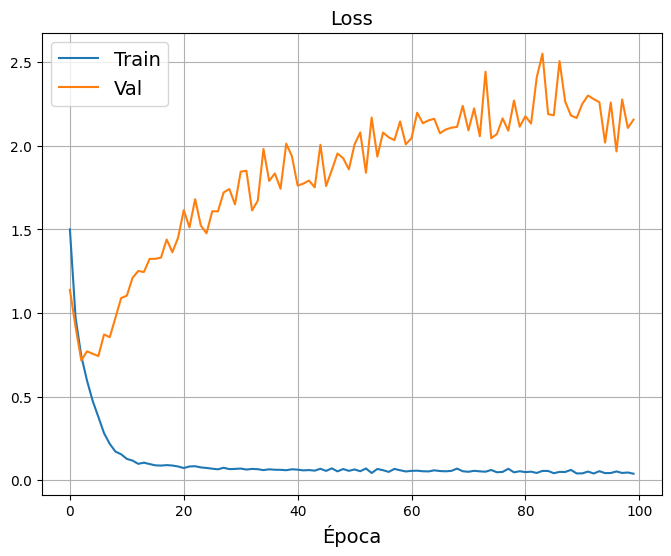

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Época', fontsize=14)
plt.legend(['Train', 'Val'], fontsize=14)
plt.title('Loss', fontsize=14)
plt.grid()
plt.show()

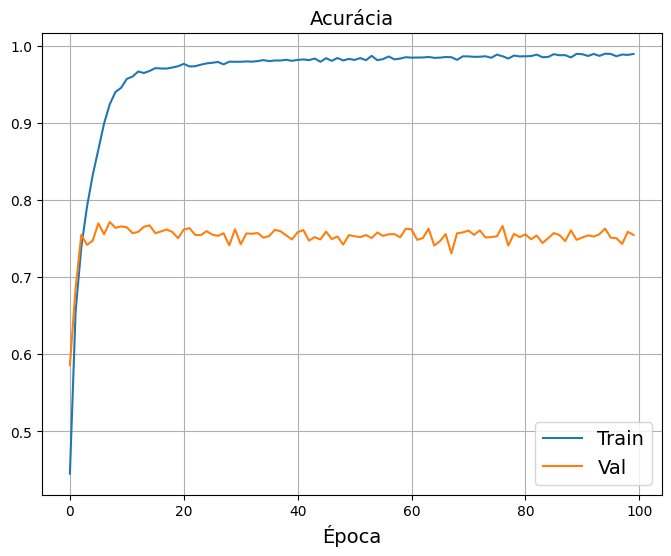

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Época', fontsize=14)
plt.legend(['Train', 'Val'], fontsize=14)
plt.title('Acurácia', fontsize=14)
plt.grid()
plt.show()

**Observação**

Nitidamente, o modelo está se sobreajustando aos dados.

## Otimização hiperparamétrica

In [ ]:
def build_model(hp):

    # Cria o modelo sequêncial.
    model = tf.keras.Sequential()

    # Number of convolutional layers.
    numOfConvLayers = hp.Choice('numOfConvLayers', range(1, 11))

    # Seleciona o número de camadas densas.
    numOfDenseLayers = hp.Choice('numOfDenseLayers', range(0, 3))

    # Seleciona o tmanho dos filtros.
    filterSize = hp.Choice('filterSize', [8, 16, 32, 64])

    # Seleciona a função de ativação.
    activation = hp.Choice('activation', ['relu', 'tanh'])

    # Seleciona o otimizador.
    optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'nadam'])

    # Seleciona o kernel size.
    kernelSize = hp.Choice('kernelSize', [2, 4, 6])

    # Adiciona camadas convolucionais.
    for i in range(numOfConvLayers):
        if(i==0):
            model.add(tf.keras.layers.Conv2D(filters=filterSize, kernel_size=kernelSize, activation=activation, padding='same', input_shape=(32, 32, 3)))
        else:
            model.add(tf.keras.layers.Conv2D(filters=filterSize*(i+1), kernel_size=kernelSize, activation=activation, padding='same'))
        if(i % 2 != 0):
            model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Adiciona camada de achatamento.
    model.add(tf.keras.layers.Flatten())

    # Adiciona camadas densas.
    for i in range(numOfDenseLayers):
        numberOfNodes = hp.Choice('numberOfNodes', [1024, 512, 256, 128, 64])
        model.add(tf.keras.layers.Dense(units=numberOfNodes//(i+1), activation=activation, kernel_initializer='he_uniform'))

    # Adiciona a camada de saída.
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

    # Compile the defined model.
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Retorna o modelo.
    return model

### Usando otimização bayesiana para encontrar os melhores hiperparâmetros.

A otimização bayesiana é uma técnica utilizada no contexto de otimização de hiperparâmetros, como a seleção dos melhores hiperparâmetros para um modelo de aprendizado de máquina. No Keras Tuner, a otimização bayesiana é uma das estratégias de busca que você pode escolher para encontrar os melhores hiperparâmetros para o seu modelo.

A otimização bayesiana funciona explorando de forma eficiente o espaço de hiperparâmetros por meio de um processo probabilístico. Em vez de testar todas as combinações possíveis de hiperparâmetros, que pode ser demorado e computacionalmente caro, a otimização bayesiana mantém uma distribuição de probabilidade das funções objetivas (por exemplo, a precisão do modelo) e usa essa distribuição para decidir quais configurações de hiperparâmetros devem ser avaliadas em seguida.

A ideia principal por trás da otimização bayesiana é encontrar um equilíbrio entre a *exploration* (tentar diferentes configurações de hiperparâmetros) e a *exploitation* (focar nas configurações de hiperparâmetros que têm a maior probabilidade de levar a melhores resultados).

À medida que mais avaliações de modelos são feitas, a distribuição de probabilidade é atualizada, permitindo que a otimização bayesiana refine progressivamente sua busca em direção às melhores configurações de hiperparâmetros.

In [ ]:
# Instanciando um objeto da classe BayesianOptimization.
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50
)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

tuner.search(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    batch_size=64,
    epochs=50,
    callbacks=[stop_early]
)

Trial 10 Complete [00h 03m 36s]
val_loss: 1.155137062072754

Best val_loss So Far: 0.7357670664787292
Total elapsed time: 01h 23m 43s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
5                 |6                 |numOfConvLayers
0                 |2                 |numOfDenseLayers
32                |32                |filterSize
relu              |relu              |activation
sgd               |adam              |optimizer
3                 |2                 |kernelSize
256               |512               |numberOfNodes

Epoch 1/50
782/782 [==============================] - 10s 11ms/step - loss: 2.1008 - accuracy: 0.2320 - val_loss: 1.8782 - val_accuracy: 0.3293
Epoch 2/50
782/782 [==============================] - 8s 10ms/step - loss: 1.7589 - accuracy: 0.3756 - val_loss: 2.2016 - val_accuracy: 0.2582
Epoch 3/50
782/782 [==============================] - 8s 10ms/step - loss: 1.5455 - accuracy: 0.4491 - val_loss: 1.4813 - val_accuracy: 0.460

In [ ]:
tuner.results_summary()